In [16]:
import time
import os
import netCDF4
import datetime
import numpy as np
import cmocean
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cpf
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE

# Constants

In [17]:
start_date = "20250204"
lead_times_figure = [0, 3, 9]
sizefont = 20
map_params = {"LAND_highres": cpf.NaturalEarthFeature("physical", "land", "50m", edgecolor = "face", facecolor = "tan", linewidth = 0.1),
              "map_extent": (-22, 53, 68, 90),
              "map_proj": ccrs.LambertAzimuthalEqualArea(central_longitude = 0, central_latitude = 79, false_easting = 0.0, false_northing = 0.0, globe = None),
              "levels": np.linspace(0, 100, 21),
              "norm": BoundaryNorm(np.linspace(0, 100, 21), 256),
              #"colormap": cmocean.cm.ice,
              #"colormap": plt.cm.gist_earth_r,
              "colormap": plt.cm.cubehelix,
              "map_extent_domains": (-22, 53, 68, 90),
              "norm_domains": BoundaryNorm(np.linspace(0, 3, 4), 256),
              "colormap_domains": "magma_r"}

paths = {}
paths["AICE"] = "/lustre/storeB/project/fou/hi/oper/aice/archive/"
paths["Barents"] = "/lustre/storeB/project/copernicus/cosi/PCAPS/Barents_AICE_grid/"
paths["AMSR2"] = "/lustre/storeB/project/copernicus/cosi/WP3/Operational/AMSR2_obs/"
paths["output"] = "/lustre/storeB/users/cyrilp/AICE/Figures/Paper/"

lead_times = np.arange(10)
Barents_N_members = 6


# Load data

In [18]:
class load_data():
    def __init__(self, start_date, paths, lead_times):
        self.start_date = start_date
        self.paths = paths
        self.lead_times = lead_times

    def load_AICE(self):
        AICE = {}
        filename = self.paths["AICE"] + "AICE_forecasts_" + self.start_date + "T000000Z.nc"
        if os.path.isfile(filename) == True:
            with netCDF4.Dataset(filename, "r") as nc:
                for var in nc.variables:
                    AICE[var] = nc.variables[var][:]
        return AICE

    def load_AMSR2_persistence(self):
        AMSR2_persistence = {}
        date_pers = (datetime.datetime.strptime(self.start_date, "%Y%m%d") - datetime.timedelta(days = 1)).strftime("%Y%m%d")
        filename = self.paths["AMSR2"] + date_pers[0:4] + "/" + date_pers[4:6] + "/" + "AMSR2_SIC_AICE_grid_" + date_pers + "T000000Z.nc"
        if os.path.isfile(filename) == True:
            with netCDF4.Dataset(filename, "r") as nc:
                AMSR2_persistence["SIC"] = np.copy(nc.variables["SIC"][0,:,:])
        return AMSR2_persistence

    def load_AMSR2(self):
        AMSR2 = {}
        for lti, leadtime in enumerate(self.lead_times):
            date_lti = (datetime.datetime.strptime(self.start_date, "%Y%m%d") + datetime.timedelta(days = int(leadtime))).strftime("%Y%m%d")
            filename = self.paths["AMSR2"] + date_lti[0:4] + "/" + date_lti[4:6] + "/" + "AMSR2_SIC_AICE_grid_" + date_lti + "T000000Z.nc"
            if os.path.isfile(filename) == True:
                with netCDF4.Dataset(filename, "r") as nc:
                    if lti == 0:
                        AMSR2["SIC"] = np.copy(nc.variables["SIC"][:,:,:])
                    else:
                        AMSR2["SIC"] = np.concatenate((AMSR2["SIC"], nc.variables["SIC"][:,:,:]), axis = 0)
            else:
                if lti == 0:
                    AMSR2["SIC"] = np.full((1, self.ydim, self.xdim), np.nan)
                else:
                    AMSR2["SIC"] = np.concatenate((AMSR2["SIC"], np.full((1, self.ydim, self.xdim), np.nan)), axis = 0)
        return AMSR2 

    def load_Barents_domain(self):
        Barents_domain = {}
        filename =  "/lustre/storeB/project/fou/hi/oper/barents_eps/archive/surface/2024/09/08/T00Z/barents_sfc_20240908T00Zm00.nc"
        with netCDF4.Dataset(filename, "r") as nc:
            for var in ["lat", "lon"]:
                Barents_domain[var] = nc.variables[var][:]
        Barents_domain["mask"] = np.ones(np.shape(Barents_domain["lon"]))
        return Barents_domain

    def load_Barents(self):
        Barents = {}
        filename = self.paths["Barents"] + self.start_date[0:4] + "/" + self.start_date[4:6] + "/" + "Barents_on_AICE_grid_" + self.start_date + ".nc"
        with netCDF4.Dataset(filename, "r") as nc:
            for var in nc.variables:
                Barents[var] = nc.variables[var][:]
        return Barents

    def __call__(self):
        AICE = self.load_AICE()
        self.xdim = len(AICE["x"])
        self.ydim = len(AICE["y"])
        AMSR2_persistence = self.load_AMSR2_persistence()
        AMSR2 = self.load_AMSR2()
        Barents_domain = self.load_Barents_domain()
        Barents = self.load_Barents()
        return(AICE, AMSR2_persistence, AMSR2, Barents_domain, Barents)

# Figure

In [19]:
def make_figure(AICE, AMSR2_persistence, AMSR2, Barents_domain, paths, lead_times_figure, sizefont, map_params, start_date, saving = False):
    labels_fig = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)"]
    date_pers = (datetime.datetime.strptime(start_date, "%Y%m%d") - datetime.timedelta(days = 1)).strftime("%Y%m%d")

    plt.figure()
    plt.rc("xtick", labelsize = sizefont)
    plt.rc("ytick", labelsize = sizefont)
    fig, axs = plt.subplots(2, len(lead_times_figure) + 1, figsize = (20, 9), facecolor = "w", edgecolor = "k")
    fig.subplots_adjust(hspace = 0.2, wspace = 0.15)
    axs = axs.ravel()

    axs[0] = plt.subplot(2, len(lead_times_figure) + 1, 1, projection = map_params["map_proj"])
    axs[0].set_extent(map_params["map_extent_domains"], crs = cartopy.crs.PlateCarree())
    axs[0].add_feature(map_params["LAND_highres"], zorder = 1)
    axs[0].coastlines(resolution = "50m", color = 'black', linewidth = 1)
    cs = axs[0].pcolormesh(Barents_domain["lon"], Barents_domain["lat"], Barents_domain["mask"][0:-1, 0:-1], transform = ccrs.PlateCarree(), norm = map_params["norm_domains"], cmap = map_params["colormap_domains"], zorder = 0, shading = "flat", alpha = 0.5)
    cs = axs[0].pcolormesh(AICE["lon"], AICE["lat"], np.full(np.shape(AICE["lat"]), 2)[0:-1, 0:-1], transform = ccrs.PlateCarree(), norm = map_params["norm_domains"], cmap = map_params["colormap_domains"], zorder = 0, shading = "flat", alpha = 0.3)
    axs[0].set_title("MET-AICE and \n Barents-2.5 domains", fontsize = sizefont)
    axs[0].text(-0.1, 0, labels_fig[0], fontsize = sizefont, ha = "left", transform = axs[0].transAxes) 

    for lti, leadtime in enumerate(lead_times_figure): # MET-AICE
        date_lt = (datetime.datetime.strptime(start_date, "%Y%m%d") + datetime.timedelta(days = int(leadtime))).strftime("%Y%m%d")
        axs[lti + 1] = plt.subplot(2, len(lead_times_figure) + 1, lti + 2, projection = map_params["map_proj"])
        axs[lti + 1].set_extent(map_params["map_extent"], crs = cartopy.crs.PlateCarree())
        axs[lti + 1].add_feature(map_params["LAND_highres"], zorder = 1)
        cs = axs[lti + 1].pcolormesh(AICE["lon"], AICE["lat"], AICE["SIC"][leadtime, 0:-1,0:-1], transform = ccrs.PlateCarree(), norm = map_params["norm"], cmap = map_params["colormap"], zorder = 0, shading = "flat")
        if lti == 0:
            axs[lti + 1].set_title("MET-AICE " + date_lt[6:8] + "-" + date_lt[4:6] + "-" + date_lt[0:4] + "\n lead time: " + str(leadtime + 1) + " day", fontsize = sizefont)
        else:
            axs[lti + 1].set_title("MET-AICE " + date_lt[6:8] + "-" + date_lt[4:6] + "-" + date_lt[0:4] + "\n lead time: " + str(leadtime + 1) + " days", fontsize = sizefont)
        axs[lti + 1].text(-0.1, 0, labels_fig[len(lead_times_figure) + lti + 2], fontsize = sizefont, ha = "left", transform = axs[len(lead_times_figure) + lti + 2].transAxes)

    axs[len(lead_times_figure) + 1] = plt.subplot(2, len(lead_times_figure) + 1, len(lead_times_figure) + 2, projection = map_params["map_proj"])  # AMSR2 persistence
    axs[len(lead_times_figure) + 1].set_extent(map_params["map_extent"], crs = cartopy.crs.PlateCarree())
    axs[len(lead_times_figure) + 1].add_feature(map_params["LAND_highres"], zorder = 1)
    cs = axs[len(lead_times_figure) + 1].pcolormesh(AICE["lon"], AICE["lat"], AMSR2_persistence["SIC"][0:-1,0:-1], transform = ccrs.PlateCarree(), norm = map_params["norm"], cmap = map_params["colormap"], zorder = 0, shading = "flat")
    axs[len(lead_times_figure) + 1].set_title("AMSR2 " + date_pers[6:8] + "-" + date_pers[4:6] + "-" + date_pers[0:4] + " (persistence)", fontsize = sizefont)
    axs[len(lead_times_figure) + 1].text(-0.1, 0, labels_fig[len(lead_times_figure) + 1], fontsize = sizefont, ha = "left", transform = axs[len(lead_times_figure) + 1].transAxes) 

    for lti, leadtime in enumerate(lead_times_figure): # AMSR2
        date_lt = (datetime.datetime.strptime(start_date, "%Y%m%d") + datetime.timedelta(days = int(leadtime))).strftime("%Y%m%d")
        axs[len(lead_times_figure) + lti + 2] = plt.subplot(2, len(lead_times_figure) + 1, len(lead_times_figure) + lti + 3, projection = map_params["map_proj"])
        axs[len(lead_times_figure) + lti + 2].set_extent(map_params["map_extent"], crs = cartopy.crs.PlateCarree())
        axs[len(lead_times_figure) + lti + 2].add_feature(map_params["LAND_highres"], zorder = 1)
        cs = axs[len(lead_times_figure) + lti + 2].pcolormesh(AICE["lon"], AICE["lat"], AMSR2["SIC"][leadtime, 0:-1,0:-1], transform = ccrs.PlateCarree(), norm = map_params["norm"], cmap = map_params["colormap"], zorder = 0, shading = "flat")
        axs[len(lead_times_figure) + lti + 2].set_title("AMSR2 " + date_lt[6:8] + "-" + date_lt[4:6] + "-" + date_lt[0:4], fontsize = sizefont)
        axs[len(lead_times_figure) + lti + 2].text(-0.1, 0, labels_fig[lti + 1], fontsize = sizefont, ha = "left", transform = axs[lti + 1].transAxes) 

    cbar_ax_1 = fig.add_axes([0.16, 0.05, 0.7, 0.03])
    cbar_1 = fig.colorbar(cs, cax = cbar_ax_1, ticks = map_params["levels"], orientation = "horizontal", extend = None)
    cbar_1.set_label("Sea ice concentration (%)", fontsize = sizefont)

    if saving == True:
        plt.savefig(paths["output"] + "Maps_AMSR2_AICE_" + start_date + ".png", bbox_inches = "tight", dpi = 300)
    else:
        plt.show()

# Data processing

/tmp/ipykernel_3845398/3493074788.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs[0] = plt.subplot(2, len(lead_times_figure) + 1, 1, projection = map_params["map_proj"])
/tmp/ipykernel_3845398/3493074788.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs[lti + 1] = plt.subplot(2, len(lead_times_figure) + 1, lti + 2, projection = map_params["map_proj"])
/tmp/ipykernel_3845398/3493074788.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs[lti + 1] = plt.subplot(2, len(lead_times_figure) + 1, lti + 2, projection = map_params["map_proj"])
/tmp/ipykernel_3845398/3493074788.py:23: MatplotlibDepr

Computing time:  9.640807151794434


<Figure size 640x480 with 0 Axes>

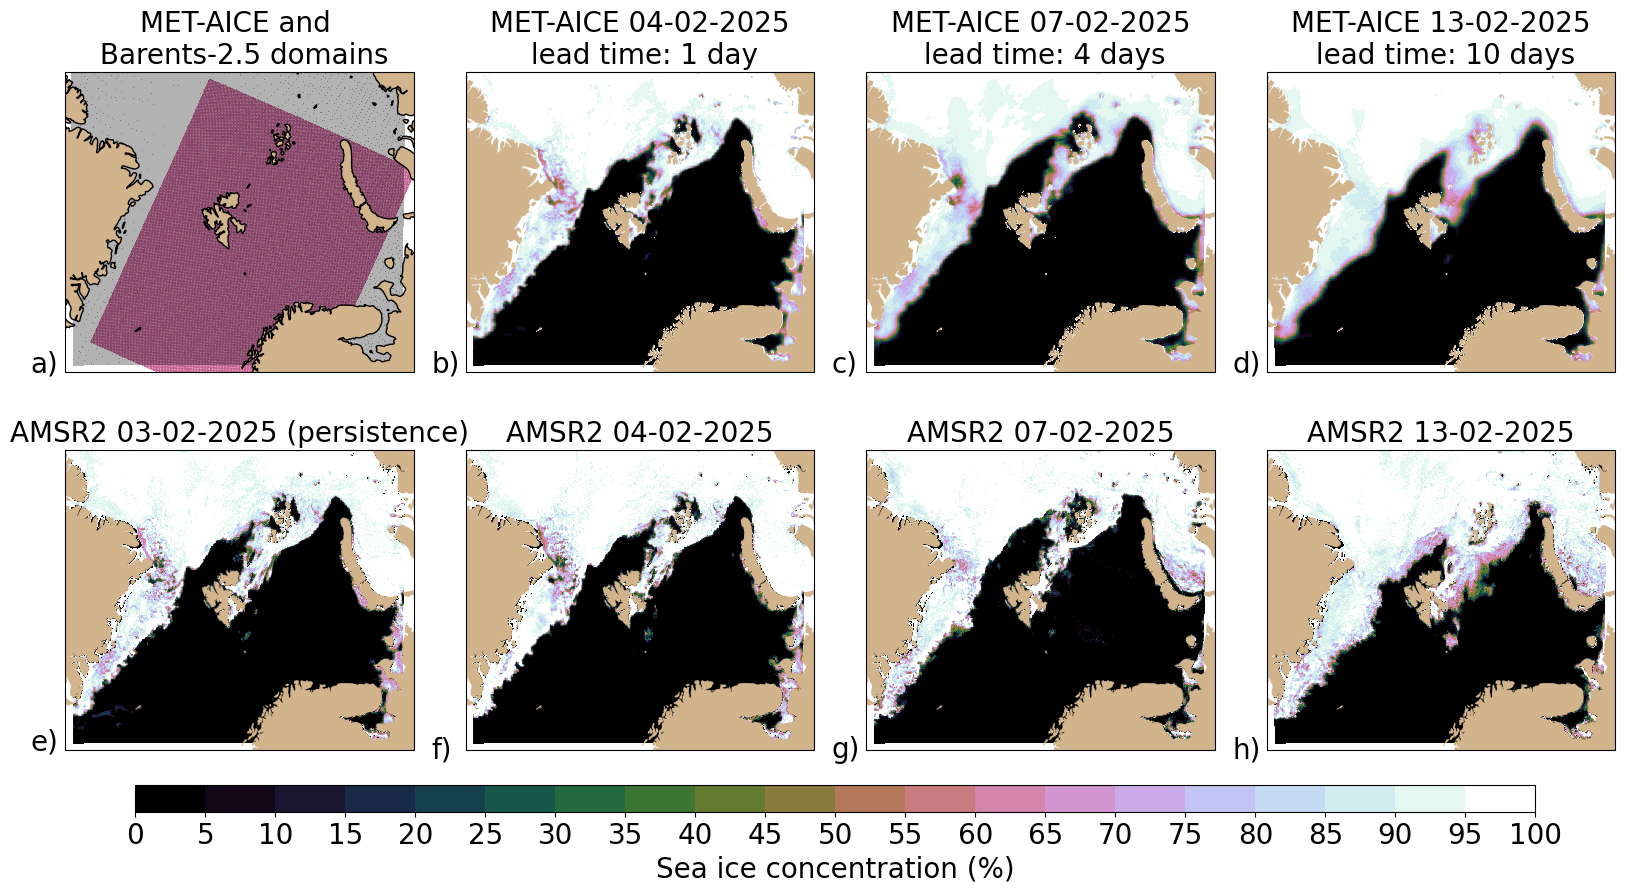

In [20]:
t0 = time.time()
AICE, AMSR2_persistence, AMSR2, Barents_domain, Barents = load_data(start_date = start_date, 
                                                                    paths = paths, 
                                                                    lead_times = lead_times)()

make_figure(AICE = AICE, 
            AMSR2_persistence = AMSR2_persistence,
            AMSR2 = AMSR2, 
            Barents_domain = Barents_domain, 
            paths = paths, 
            lead_times_figure = lead_times_figure, 
            sizefont = sizefont, 
            map_params = map_params, 
            start_date = start_date, 
            saving = True)
tf = time.time()
print("Computing time: ", tf - t0)